# Train model to recognise generated and original voice of same person

In [1]:
from torchaudio import transforms
from IPython.display import Audio
from torch.utils.data import random_split
import torchaudio
from enum import Enum
import pandas as pd
import torch
from src.utils.plot import plot
import torch.nn as nn
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F

In [2]:
SAMPLE_RATE = 16000

DATASET_PATH = './dataset/'
DATA_PATH = './data/'
MODEL_SAVE_PATH = './model_save/'

In [3]:
class SiameseNetwork(nn.Module):
	def __init__(self, input_size, hidden_size, num_layers):
		super(SiameseNetwork, self).__init__()
		self.hidden_size = hidden_size
		self.num_layers = num_layers
		self.lstm = nn.LSTM(input_size, hidden_size, num_layers, batch_first=True)
		self.fc = nn.Linear(hidden_size, 512)

		self.final = nn.Linear(512, 2)

	def forward_once(self, x):
		output, _ = self.lstm(x)
		output = self.fc(output[:, -1, :])
		return output

	def forward(self, input1, input2):
		output1 = self.forward_once(input1)
		output2 = self.forward_once(input2)
		return self.final(torch.abs(output1 - output2))

In [4]:
from numpy.typing import NDArray
import numpy as np
class AudioToTimeSeriesTransform:
    def __init__(
            self,
            n_fft,
            hop_len=None,
            win_length=None,
            top_db=80,
            normalize=False
    ):
        self.spectrogram = transforms.Spectrogram(
            n_fft=n_fft,
            win_length=win_length,
            hop_length=hop_len,
        )
        self.amplitude_to_db = transforms.AmplitudeToDB(top_db=top_db)
        self.normalize = normalize

    def __call__(self, samples: NDArray[np.float32], _: int):
        samples = torch.from_numpy(samples)
        spec = self.spectrogram(samples)
        spec = self.amplitude_to_db(spec)
        spec = spec.permute(1, 0)
        spec = spec.squeeze(0)
        return (spec)

In [5]:
from src.transform.transform import CustomAdjustDurationTransform, ResampleTransform, CustomAdjustDurationTransform, ShiftWrapperTransform
from src.transform.composite_transformation import CompositeTransformation

train_transform = CompositeTransformation(
	[
		ResampleTransform(target_sample_rate=SAMPLE_RATE),
		CustomAdjustDurationTransform(duration_seconds=3),
		ShiftWrapperTransform(min_shift=-0.2, max_shift=0.2),
		AudioToTimeSeriesTransform(n_fft=256)
	]
)

test_transform = CompositeTransformation(
	[
		ResampleTransform(target_sample_rate=SAMPLE_RATE),
		CustomAdjustDurationTransform(duration_seconds=3),
		ShiftWrapperTransform(min_shift=0, max_shift=0),
		AudioToTimeSeriesTransform( n_fft=256)
	]
)

In [6]:
import librosa

from src.columns.generated_dataset_column import GeneratedDatasetColumn
from src.transform.transform import CustomAdjustDurationTransform, ResampleTransform, ToMelSpectrogramTransform
import torch
from torch.utils.data import Dataset

from src.transform.composite_transformation import CompositeTransformation


class GeneratedLSTMSoundDS(Dataset):
    def __init__(
        self,
        voiceDataset,
        original_voice_data_path,
        generated_voice_data_path,
        sample_rate=16000,
        duration=3,
        transform=None
    ):
        self.voiceDataset = voiceDataset
        self.original_voice_data_path = str(original_voice_data_path)
        self.generated_voice_data_path = str(generated_voice_data_path)
        self.duration = duration
        self.sample_rate = sample_rate
        self.transform = None
        if transform is not None:
            self.transform = transform
        else:
            self.transform = CompositeTransformation(
                [
                    ResampleTransform(target_sample_rate=sample_rate),
                    CustomAdjustDurationTransform(duration_seconds=duration),
		            AudioToTimeSeriesTransform( n_fft=256)
                ]
            )

    def __len__(self):
        return len(self.voiceDataset)

    def _get_sgram(self, audio_file):
        audio, sample_rate = librosa.load(audio_file, sr=self.sample_rate)
        spectrogram = self.transform.transform((audio, sample_rate))
        return spectrogram

    def _get_sample_path(self, path, source):
        data_path = self.original_voice_data_path if source == 'original' else self.generated_voice_data_path
        return data_path + path

    def _get_label(self, label):
        return torch.tensor(1 if label else 0, dtype=torch.int64)

    def __getitem__(self, idx):
        anchor_path, posneg_path, _, _, anchor_source, posneg_source, label = self.voiceDataset.iloc[idx][
            [
                GeneratedDatasetColumn.ANCHOR_PATH,
                GeneratedDatasetColumn.POSNEG_PATH,
                GeneratedDatasetColumn.ANCHOR_ID,
                GeneratedDatasetColumn.POSNEG_ID,
                GeneratedDatasetColumn.SOURCE_ANCHOR,
                GeneratedDatasetColumn.SOURCE_POSNEG,
                GeneratedDatasetColumn.LABEL
            ]
        ].values.tolist()

        anchor_file = self._get_sample_path(anchor_path, anchor_source)
        posneg_file = self._get_sample_path(posneg_path, posneg_source)
        label = self._get_label(label)
        anchor_sgram = self._get_sgram(anchor_file)
        posneg_sgram = self._get_sgram(posneg_file)

        return anchor_sgram, posneg_sgram, label


In [7]:

train_df = pd.read_csv(DATASET_PATH + "train_base_dataset.csv")
train_ds = GeneratedLSTMSoundDS(train_df, original_voice_data_path=DATA_PATH + "validated_16000/", generated_voice_data_path=DATA_PATH + "generated_16000/", transform=train_transform)

test_df = pd.read_csv(DATASET_PATH + "test_base_dataset.csv")
test_ds = GeneratedLSTMSoundDS(test_df, original_voice_data_path=DATA_PATH + "validated_16000/", generated_voice_data_path=DATA_PATH + "generated_16000/", transform=test_transform)

In [8]:
import matplotlib.pyplot as plt
def plot_lstm(sample):
	def plot_spec(ax, spec, title):
		ax.set_title(title)
		ax.imshow(spec, origin="lower", aspect="auto")
		ax.invert_yaxis()
	fig, axes = plt.subplots(1, 2, sharex=True, sharey=True)
	posneg = "same voice"
	if not sample[2]:
		posneg = "other or generated vocie"
	plot_spec(axes[0], sample[0], title="Original")
	plot_spec(axes[1], sample[1], title=posneg)
	fig.tight_layout()

In [9]:
data_shape= train_ds[0][0].shape

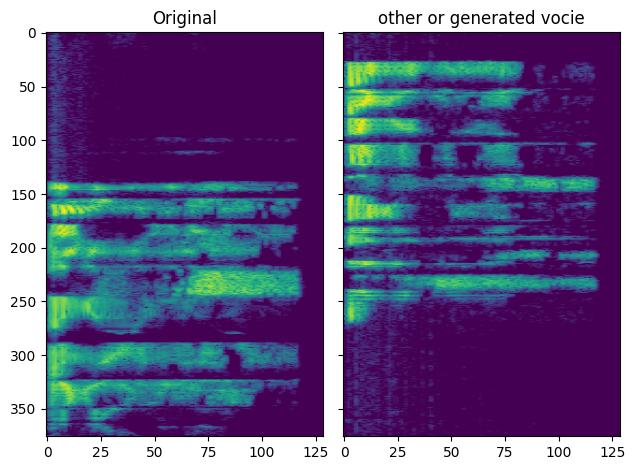

In [10]:
plot_lstm(train_ds[67])

In [11]:
train_dl = torch.utils.data.DataLoader(train_ds, batch_size=16, shuffle=True)
test_dl = torch.utils.data.DataLoader(test_ds, batch_size=16, shuffle=True)

In [12]:
class CrossEntropyLoss(torch.nn.Module):
	def __init__(self):
		super(CrossEntropyLoss, self).__init__()

	def forward(self, output, label):
		label = label.long()
		loss = F.cross_entropy(output, label)
		return loss

In [13]:
class SiameseNetwork(nn.Module):
	def __init__(self, input_size, hidden_size, num_layers):
		super(SiameseNetwork, self).__init__()
		self.hidden_size = hidden_size
		self.num_layers = num_layers
		self.lstm = nn.LSTM(input_size, hidden_size, num_layers, batch_first=True)
		self.fc = nn.Linear(hidden_size, 512)

		self.final = nn.Linear(512, 2)

	def forward_once(self, x):
		output, _ = self.lstm(x)
		output = self.fc(output[:, -1, :])
		return output

	def forward(self, input1, input2):
		output1 = self.forward_once(input1)
		output2 = self.forward_once(input2)
		return self.final(torch.abs(output1 - output2))

In [14]:
num_epochs = 5
siamese_model = SiameseNetwork(input_size=data_shape[-1], hidden_size=512, num_layers=5).to('cuda')
criterion = CrossEntropyLoss().to('cuda')
optimizer = optim.Adam(siamese_model.parameters(), lr=0.001)
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [15]:
from src.trainer.siamese_trainer import evaluate_siamese_model, train_siamese_model
loss, accuracy, precision, recall, f1 = [], [], [], [], []
for epoch in range(num_epochs):
	_train_loss, _train_accuracy, _train_precision, _train_recall, _train_f1 = train_siamese_model(siamese_model, train_dl, criterion, optimizer, device)
	print(f"Epoch {epoch + 1}/{num_epochs}, Loss: {_train_loss:.4f}, "f"Accuracy: {_train_accuracy:.4f}, Precision: {_train_precision:.4f}, Recall: {_train_recall:.4f}, F1: {_train_f1:.4f}")
	_test_loss, _test_accuracy, _test_precision, _test_recall, _test_f1 = evaluate_siamese_model(siamese_model, test_dl, criterion, device)
	print(f"Epoch {epoch + 1}/{num_epochs}, Loss: {_test_loss:.4f}, "f"Accuracy: {_test_accuracy:.4f}, Precision: {_test_precision:.4f}, Recall: {_test_recall:.4f}, F1: {_test_f1:.4f}")
	loss.append([_train_loss, _test_loss])
	accuracy.append([_train_accuracy, _test_accuracy])
	precision.append([_train_precision, _test_precision])
	recall.append([_train_recall, _test_recall])
	f1.append([_train_f1, _test_f1])


Epoch 1/5, Loss: 0.6942, Accuracy: 0.5009, Precision: 0.5005, Recall: 0.9533, F1: 0.6564


Epoch 1/5, Loss: 0.6930, Accuracy: 0.5464, Precision: 0.5249, Recall: 0.9768, F1: 0.6829


Epoch 2/5, Loss: 0.6932, Accuracy: 0.5004, Precision: 0.5002, Recall: 0.8096, F1: 0.6184


KeyboardInterrupt: 

In [ ]:
import matplotlib.pyplot as plt

def plot_metrix(loss, accuracy):
	epochs = range(1, len(loss) + 1)

	fig, axs = plt.subplots(2, 1, figsize=(12, 8))
	fig.suptitle("Model Metrics")


	axs[0].plot(epochs, [e[0] for e in loss], label=" Train loss", color="g")
	axs[0].plot(epochs, [e[1] for e in loss], label="Test loss", color="b")
	axs[0].set_title("Loss")
	axs[0].set_xlabel("Epoch")
	axs[0].set_ylabel("Loss")

	axs[1].plot(epochs, [e[0] for e in accuracy], label="Train accuracy", color="g")
	axs[1].plot(epochs, [e[1] for e in accuracy], label="Test accuracy", color="b")
	axs[1].set_title("Accuracy")
	axs[1].set_xlabel("Epoch")
	axs[1].set_ylabel("Accuracy")

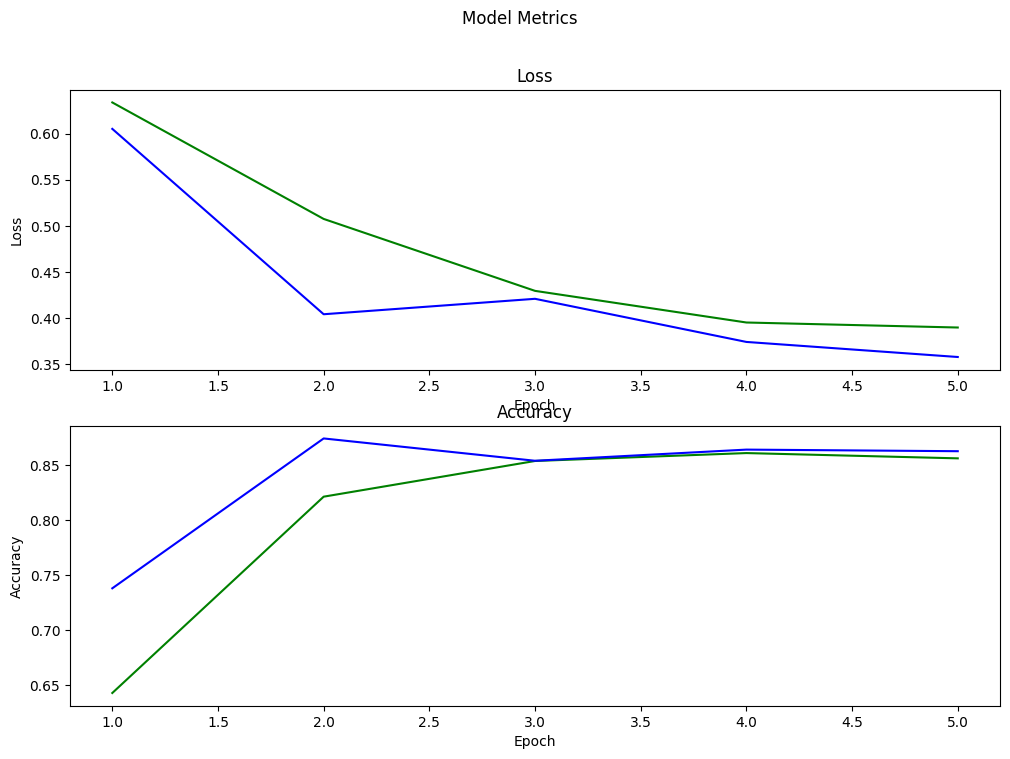

In [ ]:
plot_metrix(loss, accuracy)

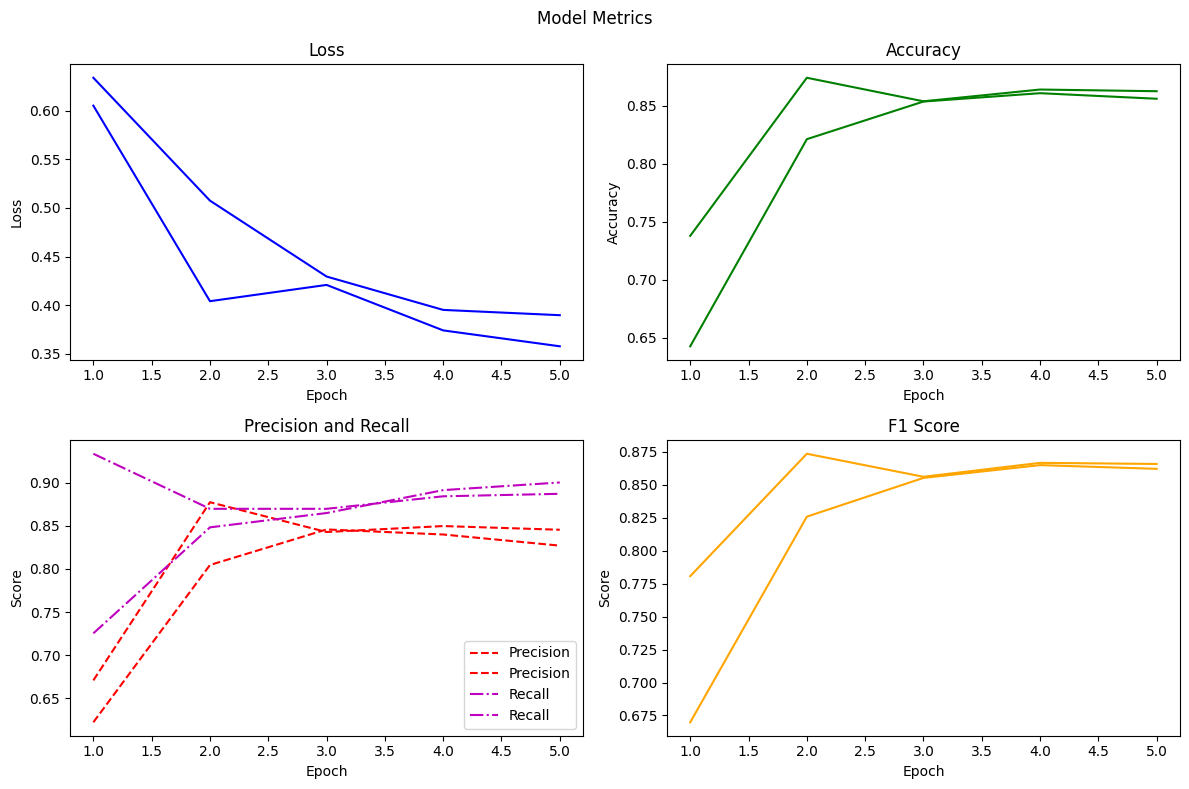

In [ ]:
import matplotlib.pyplot as plt

epochs = range(1, len(loss) + 1)  


fig, axs = plt.subplots(2, 2, figsize=(12, 8))
fig.suptitle("Model Metrics")


axs[0, 0].plot(epochs, loss, label="Loss", color="b")
axs[0, 0].set_title("Loss")
axs[0, 0].set_xlabel("Epoch")
axs[0, 0].set_ylabel("Loss")

axs[0, 1].plot(epochs, accuracy, label="Accuracy", color="g")
axs[0, 1].set_title("Accuracy")
axs[0, 1].set_xlabel("Epoch")
axs[0, 1].set_ylabel("Accuracy")


axs[1, 0].plot(epochs, precision, label="Precision", color="r", linestyle="--")
axs[1, 0].plot(epochs, recall, label="Recall", color="m", linestyle="-.")
axs[1, 0].set_title("Precision and Recall")
axs[1, 0].set_xlabel("Epoch")
axs[1, 0].set_ylabel("Score")
axs[1, 0].legend()


axs[1, 1].plot(epochs, f1, label="F1 Score", color="orange")
axs[1, 1].set_title("F1 Score")
axs[1, 1].set_xlabel("Epoch")
axs[1, 1].set_ylabel("Score")

plt.tight_layout()
plt.show()

In [ ]:
torch.save(siamese_model.to('cpu'), 'my_lstm_g_model.pt')

In [ ]:
import matplotlib.pyplot as plt
def explain_model(model: torch.nn.Module, anchor_sgram: torch.tensor, posneg_sgram: torch.tensor, mode: str = "PREDICTED"):
	allowed_mode = ["GENERATED_CLASS, ORIGIN_CLASS", "PREDICTED"]
	if mode not in allowed_mode:
		raise ValueError()
	model.eval()
	model.cpu()
	model.zero_grad()
	anchor_sgram = torch.clone(anchor_sgram)
	posneg_sgram = torch.clone(posneg_sgram)

	anchor_sgram.unsqueeze_(0)
	posneg_sgram.unsqueeze_(0)
	anchor_sgram.requires_grad = True
	posneg_sgram.requires_grad = True

	anchor_sgram = anchor_sgram
	posneg_sgram = posneg_sgram

	predictions = model(anchor_sgram, posneg_sgram)
	if mode == "PREDICTED":
		class_id = predictions[0].argmax()
	if mode == "GENERATED_CLASS":
		class_id = 0
	if mode == "ORIGIN_CLASS":
		class_id = 1
	neuron = predictions[0, class_id]

	neuron.backward()
	anchor_slc, _ = torch.max(torch.abs(anchor_sgram.grad), dim=0)
	anchor_grad = (anchor_slc - anchor_slc.min())/(anchor_slc.max()-anchor_slc.min())

	posneg_slc, _ = torch.max(torch.abs(posneg_sgram.grad), dim=0)
	posneg_grad = (posneg_slc - posneg_slc.min())/(posneg_slc.max()-posneg_slc.min())

	return anchor_grad, posneg_grad




In [ ]:
def plot_explain_siamese_lstm_model_all(anchor_sgram, posneg_sgram, anchor_sgram_grad, posneg_sgram_grad):
	plt.figure(figsize=(5, 4))

	plt.subplot(1, 2, 1)
	plt.title("Anchor Sgram")
	plt.imshow(anchor_sgram,  origin="lower", aspect="auto")
	plt.subplot(1, 2, 2)
	plt.tight_layout()
	plt.title("Anchor Sgram Grad")
	plt.imshow(anchor_sgram_grad.numpy(), cmap=plt.cm.hot,
			   origin="lower", aspect="auto")
	plt.figure(figsize=(5, 4))
	plt.subplot(1, 2, 1)
	plt.title("PosNeg Sgram")
	plt.imshow(posneg_sgram,  origin="lower", aspect="auto")
	plt.subplot(1, 2, 2)
	plt.tight_layout()
	plt.title("PosNeg Sgram Grad")
	plt.imshow(posneg_sgram_grad.numpy(), cmap=plt.cm.hot,
			   origin="lower", aspect="auto")
	plt.show()

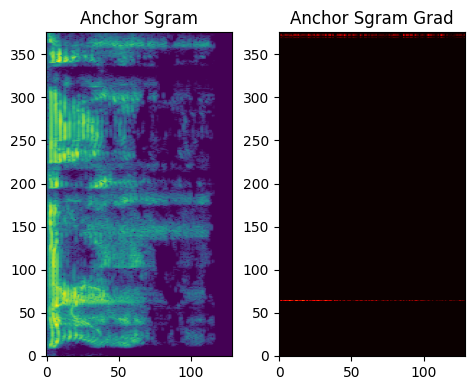

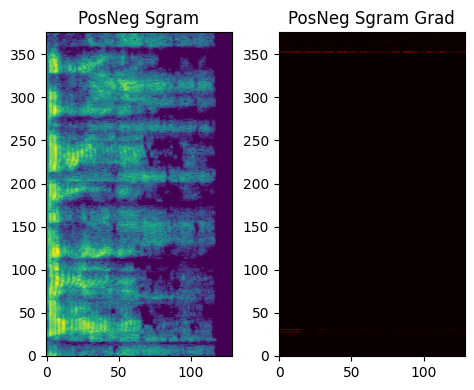

: 

In [ ]:
anchor_sgram, posneg_sgram, _ = test_ds[56]
anchor_sgram_grad, posneg_sgram_grad = explain_model(siamese_model.cpu(), anchor_sgram=anchor_sgram, posneg_sgram=posneg_sgram)
plot_explain_siamese_lstm_model_all(anchor_sgram, posneg_sgram, anchor_sgram_grad, posneg_sgram_grad)

In [ ]:
def integrated_gradients(model,anchor_sgram, posneg_sgram, baseline=None, num_steps=10):

	if baseline is None:
		anchor_baseline = torch.zeros_like(anchor_sgram)
		posneg_baseline = torch.zeros_like(posneg_sgram)

	anchor_scaled_inputs = [anchor_baseline + (float(i) / num_steps) * (anchor_sgram - anchor_baseline) for i in range(num_steps + 1)]
	posneg_scaled_inputs = [posneg_baseline + (float(i) / num_steps) * (posneg_sgram - posneg_baseline) for i in range(num_steps + 1)]
	anchor_inputs = torch.stack(anchor_scaled_inputs)
	posneg_inputs = torch.stack(posneg_scaled_inputs)
	anchor_inputs.requires_grad = True
	posneg_inputs.requires_grad = True
	model.zero_grad()
	model.eval()
	model.cpu()
	outputs = model(anchor_inputs, posneg_inputs)

	anchor_prob_predicted_class = torch.softmax(outputs, dim=1)[:, torch.argmax(outputs, dim=1)].sum()

	anchor_gradients = torch.autograd.grad(anchor_prob_predicted_class, anchor_inputs)[0]

	outputs = model(anchor_inputs, posneg_inputs)
	posneg_prob_predicted_class = torch.softmax(outputs, dim=1)[:, torch.argmax(outputs, dim=1)].sum()
	posneg_gradients = torch.autograd.grad(posneg_prob_predicted_class, posneg_inputs)[0]
	anchor_integrated_gradients = (anchor_inputs - anchor_baseline) * anchor_gradients.mean(0)
	posneg_integrated_gradients = (posneg_inputs - anchor_baseline) * posneg_gradients.mean(0)
	anchor_integrated_gradients = torch.mean(anchor_integrated_gradients, dim=0)
	posneg_integrated_gradients =torch.mean(posneg_integrated_gradients, dim=0)
	return anchor_integrated_gradients.detach().numpy(), posneg_integrated_gradients.detach().numpy()

In [ ]:
anchor_sgram, posneg_sgram, _ = test_ds[56]
anchor_sgram_grad, posneg_sgram_grad = integrated_gradients(siamese_model.cpu(), anchor_sgram=anchor_sgram, posneg_sgram=posneg_sgram)

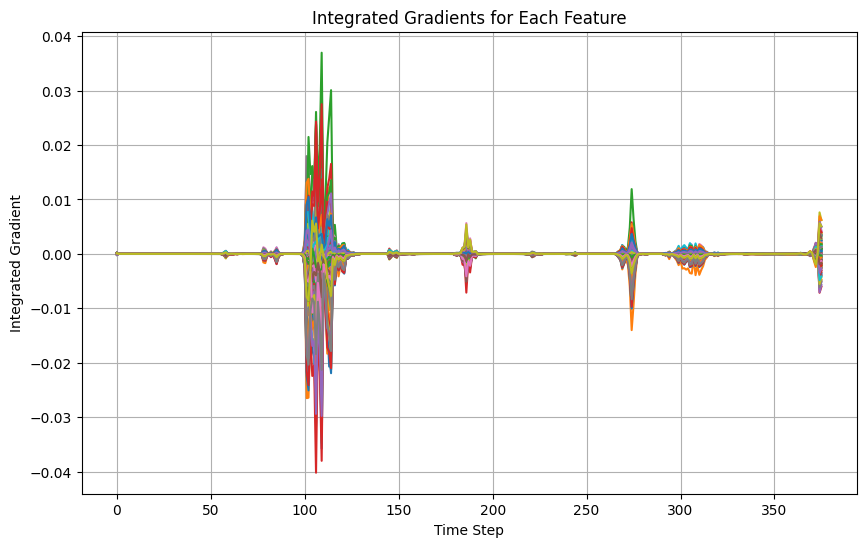

In [ ]:
import matplotlib.pyplot as plt

# Assuming 'ig' contains the computed integrated gradients

# Plot the integrated gradients for each feature
plt.figure(figsize=(10, 6))
for i in range(anchor_sgram_grad.shape[-1]):
    plt.plot(anchor_sgram_grad[:, i], label=f"Feature {i}")
plt.xlabel("Time Step")
plt.ylabel("Integrated Gradient")
plt.title("Integrated Gradients for Each Feature")
plt.grid(True)
plt.show()

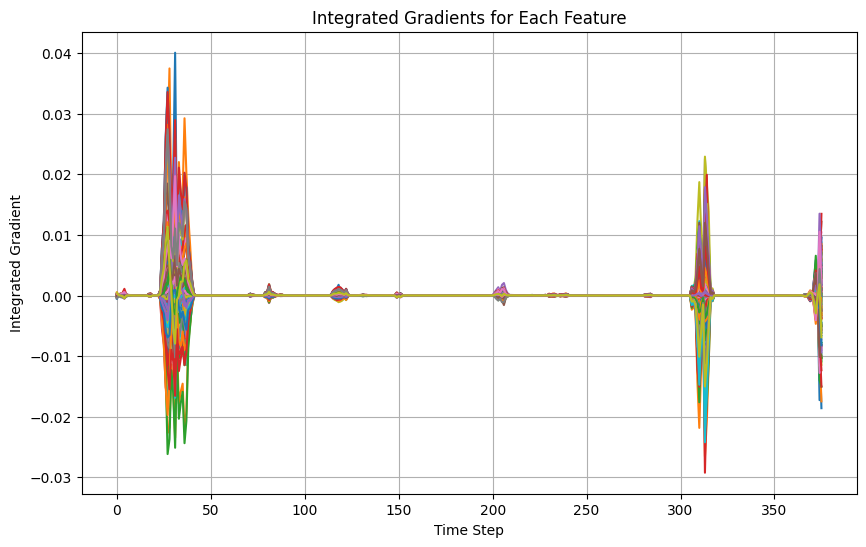

In [ ]:
plt.figure(figsize=(10, 6))
for i in range(posneg_sgram_grad.shape[-1]):
    plt.plot(posneg_sgram_grad[:, i], label=f"Feature {i}")
plt.xlabel("Time Step")
plt.ylabel("Integrated Gradient")
plt.title("Integrated Gradients for Each Feature")
plt.grid(True)
plt.show()